<a href="https://colab.research.google.com/github/ravishankarramakrishnan/Deep_Learning_Practice/blob/master/COVID19_XRay_Detection%5BRESNET18_Pytorch%5D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Detecting COVID-19 with Chest X Ray using PyTorch

Image classification of Chest X Rays in one of three classes: Normal, Viral Pneumonia, COVID-19 using Deep Learning (RESNET 18) and Pytorch

Theme: Transfer Learning of Weights from Resnet 18 


Dataset from [COVID-19 Radiography Dataset](https://www.kaggle.com/tawsifurrahman/covid19-radiography-database) on Kaggle

In [4]:
# Importing the Libraries

import numpy as np
import pandas as pd
import os
import shutil
import random
from PIL import Image
from matplotlib import pyplot as plt

import torch
import torchvision
print(f"Using Pytorch Version {torch.__version__}")

Using Pytorch Version 1.6.0+cu101


In [5]:
# Creating a Test Set from the Dataset

# Loading the Dataset - Preparing the Test Set
# Select Random 30 Images from the 3 Classes

class_names = ['normal', 'viral', 'covid']
root_dir = '/content/drive/My Drive/Projects/Detecting COVID-19 with Chest X-Ray using PyTorch/COVID-19 Radiography Database'
source_dirs = ['NORMAL', 'Viral Pneumonia', 'COVID-19']

# Create a Test Set Folder - We have Class Imbalance
if os.path.isdir(os.path.join(root_dir, source_dirs[1])):
    os.makedir(os.path.join(root_dir, 'test_new'))

    # Create Folders on Directory with the Names
    for i,d in enumerate(source_dirs):
        os.rename(os.path.join(root_dir, d), os.path.join(root_dir, class_names[i]))

    for c in class_names:
        os.mkdir(os.path.join(root_dir, 'test_new', c))

    # Select Random 30 Images from each class and put on the Test Set Folder according to the Class Name
    for c in class_names:
        images = [x for x in os.listdir(os.path.join(root_dir, c)) is x.lower().endswith('png')]
        selected_images = random.sample(images, 30)
        for image in selected_images:
            source_path = os.path.join(root_dir, c, image)
            target_path = os.path.join(root_dir, 'test_new', c, image)
            shutil.move(source_path, target_path)

In [6]:
# Creating a Custom Dataset Class for Creating Training/Test set Instances - Use Torch Data Module

class ChestXRayDataset(torch.utils.data.Dataset):
    # Get the Image Directory and Data Augmentation/Transformation Strategy 
    def __init__(self, image_dirs, transform):
        def get_images(class_name):
            # Add Validation to get Only the Images
            images = [x for x in os.listdir(image_dirs[class_name]) if x.lower().endswith('png')]
            print(f"Found {len(images)} {class_name} Examples")
            return images

        # Create a Dictionary to keep track of all Images
        self.images = {}
        self.class_names = ['normal', 'viral', 'covid']

        # Iterate over Class Names

        for c in self.class_names:
            self.images[c] = get_images(c)

        # Save it in Directory Dictionary
        self.image_dirs = image_dirs
        self.transform = transform

    # Object to Return Length of the dataset (All 3 Classes Combined)
    def __len__(self):
        return sum([len(self.images[c]) for c in self.class_names])

    def __getitem__(self, index):
        # To Avoid Class Imbalance, we Randomly select which class to return fiven any index
        class_name = random.choice(self.class_names)
        # Index is the Remainder of itself by that class examples (As Index can be Out Of Bounds (0-3k) for a particular class)
        index = index % len(self.images[class_name]) # To avoid any Out of Bounds index value
        image_name = self.images[class_name][index]
        image_path = os.path.join(self.image_dirs[class_name], image_name)
        # Load the Image
        # We Specify this convert as we use a Pretrained Model so to have 3 channels in line with the trained model
        image = Image.open(image_path).convert('RGB') # Converting Black/White Images to RGB
        
        # Pytorch doesnt Understand PIL Images, they need it to be Tensors. So we transform the Image
        return self.transform(image), self.class_names.index(class_name)

In [7]:
# Image Transformations - Modelling as per how Resnet 18 Expects
# Ensure Our Data is Processed in the Same way as the Pretrained Model to Efficiently make use of Transfer Learning

# Create 2 Transformation Objects to be applied for Training and Test Set
train_transform = torchvision.transforms.Compose([
                  torchvision.transforms.Resize(size= (224, 224)), # As per your ResNet Model (Pretrained Model)
                  torchvision.transforms.RandomHorizontalFlip(p= 0.5), # Data Augmentation
                  torchvision.transforms.ToTensor(),
                  # The below are comming from the Normalisation values done on Imagenet Dataset (ResnetWeights) - For Each different Channels / Axis (RGB) in the Tensors
                  torchvision.transforms.Normalize(mean= [0.485, 0.456, 0.406],
                                                   std= [0.229, 0.224, 0.225])
])

# Follow the above without Data Augmentation for Test Sets
test_transform =  torchvision.transforms.Compose([
                  torchvision.transforms.Resize(size= (224, 224)), # As per your ResNet Model (Pretrained Model)
                  torchvision.transforms.ToTensor(),
                  # The below are comming from the Normalisation values done on Imagenet Dataset (ResnetWeights) - For Each different Channels / Axis (RGB) in the Tensors
                  torchvision.transforms.Normalize(mean= [0.485, 0.456, 0.406],
                                                   std= [0.229, 0.224, 0.225])
])

In [9]:
# Preparing Data Loaders (Python Iterators for using dataset objects when fetch is called during training)

# Specifying paths and directory

train_dirs = {
    'normal': '/content/drive/My Drive/Projects/Detecting COVID-19 with Chest X-Ray using PyTorch/COVID-19 Radiography Database/normal',
    'viral': '/content/drive/My Drive/Projects/Detecting COVID-19 with Chest X-Ray using PyTorch/COVID-19 Radiography Database/viral',
    'covid': '/content/drive/My Drive/Projects/Detecting COVID-19 with Chest X-Ray using PyTorch/COVID-19 Radiography Database/covid'
}

test_dirs = {
    'normal': '/content/drive/My Drive/Projects/Detecting COVID-19 with Chest X-Ray using PyTorch/COVID-19 Radiography Database/test/normal',
    'viral': '/content/drive/My Drive/Projects/Detecting COVID-19 with Chest X-Ray using PyTorch/COVID-19 Radiography Database/test/viral',
    'covid': '/content/drive/My Drive/Projects/Detecting COVID-19 with Chest X-Ray using PyTorch/COVID-19 Radiography Database/test/covid'
}

In [10]:
# Creating Data Loaders by initiating the Created Class

train_dataset = ChestXRayDataset(image_dirs= train_dirs, transform= train_transform)

Found 1311 normal Examples
Found 1315 viral Examples
Found 189 covid Examples


In [11]:
# Apply the Same for Test Dataset
test_dataset = ChestXRayDataset(image_dirs= test_dirs, transform= test_transform)

Found 30 normal Examples
Found 30 viral Examples
Found 30 covid Examples


In [14]:
# Using DataLoaders from Pytorch Utils

batch_size= 6

dataload_train = torch.utils.data.DataLoader(dataset= train_dataset, batch_size= batch_size, shuffle= True)
dataload_test = torch.utils.data.DataLoader(dataset= test_dataset, batch_size= batch_size, shuffle= True)

# Validate the Number of Batches Created
print("The Number of Training Batches Created is %s " % len(dataload_train))
print("The Number of Test Batches Created is", len(dataload_test))

The Number of Training Batches Created is 470 
The Number of Test Batches Created is 15


In [15]:
# Validate the size of Train and Test Set

print(470 * 6, 'Is the Total Observations in the Training set')
print(15 * 6, 'Is the Total Observations in the Test set')

2820 Is the Total Observations in the Training set
90 Is the Total Observations in the Test set


In [19]:
display(1311+1315+189), display(30+30+30)
# The Question here is There is 2815 data in Training set, but will an entire batch be created for a single sample

2815

90

(None, None)

In [20]:
# Visualizing the Dataset

# Create a Function to show images

def show_images(images, labels, predictions):
    plt.figure(figsize= (8,4))
    # Display 1 batch at a time
    for i, image in enumerate(images):
        plt.subplot(1,6,i+1, xticks= [], yticks= []) # subplot for this instance
        # The Image and Labels are gonna be Tensors if comming from DataLoaders - Must be Channel, height width for Pretrained Model
        image = image.numpy().transpose((1,2,0)) # Channels 2 and 3 would come first then channel 1 [The 1,2,0 are indexes]
        # Normalize the Values of the Images to match the Resnet Model
        mean = np.array([0.485, 0.456, 0.406]) # Channel 1, 2, 3
        std = np.array([0.229, 0.224, 0.225])
        # Converting Image Pixel Value to Original Value 
        image = image * std + mean
        # Clip the Values of the Image between 0 and 1
        image = np.clip(image, 0., 1.)
        plt.imshow(image)

        # Display the Labels - XLabel for Ground Truth, ylabel for Prediction : Green if Correct, Red if Not Correct
        col = 'green' if predictions[i] == labels[i] else 'red'
        plt.xlabel(f"{class_names[int(labels[i].numpy())]}") # Convert labels to numpy as it is Tensor object
        plt.ylabel(f"{class_names[int(predictions[i].numpy())]}", color= col) # For Plotting as Red or Green

    plt.tight_layout()
    plt.show();

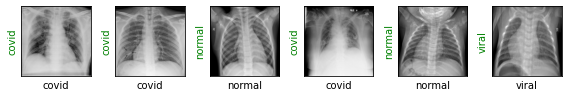

In [22]:
# Fetch a batch of Images and send to the above function
images, labels = next(iter(dataload_train)) # Iterate over and Fetch the next batch from DataLoader

# Plot Via the Function 
show_images(images, labels, labels) # We pass Labels in space of Predictions as we dont have Predictions yet

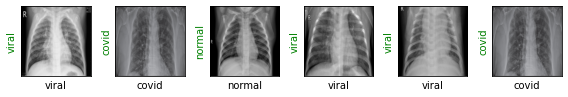

In [23]:
# Plot the Same for Test Dataset

# Fetch a batch of Images and send to the above function
images, labels = next(iter(dataload_test))

# Plot Via the Function 
show_images(images, labels, labels) 

In [24]:
# Building the Deep Learning Model using RESNET - 18 and Transfer Learning

resnet18 = torchvision.models.resnet18(pretrained= True) # It is a Smaller CNN to train the Model Quickly
print(f"The Model Architecture is: \n {resnet18}")

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth



The Model Architecture is: 
 ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     

In [25]:
# Change Last Fully Connected (fc) Layer as out_features= 3 instead of 1000 (Classes of Imagenet)
resnet18.fc = torch.nn.Linear(in_features=512, out_features=3, bias=True) # If you are doing for Middle layers, you'll need to use Activation

# For Classification, we use appropriate loss function
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(resnet18.parameters(), lr= 3e-5) # Parameters for Adam are resnet 18 parameters
# You can identify best learning rate by HyperParameter Search, running for few epochs and compare

In [26]:
# Define methods to show Predictions

def show_preds():
    # Set the Model to Evaluation Model
    resnet18.eval()
    # Iterate over Test DataLoader for Random Images
    images, labels = next(iter(dataload_test))
    outputs = resnet18(images)
    # Get the Indices of Maximum Value, like Argmax
    vals, preds = torch.max(outputs, 1) # 1 is the Dimension 1, corresponding to Values | Dimension 0 is No.of Examples
    show_images(images, labels, preds)

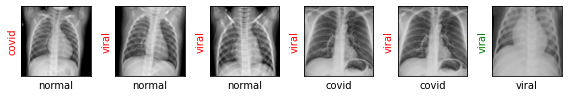

In [31]:
# Test the Functions of the Resnet Predictions - Only using Pretrained Weights

show_preds()

In [34]:
# Training the Model - Build a Train Function

def train(epochs):
    print(">> Starting Training <<")
    for e in range(0, epochs):
        print("+++"*20)
        print(f"Starting Epoch {e + 1} / {epochs}")
        print("+++"*20)

        # Keep a track of Training Loss
        train_loss = 0

        # Training the Model
        resnet18.train()

        for train_step, (images, labels) in enumerate(dataload_train):
            # Refresh optimizer by setting the Gradients to Zero
            optimizer.zero_grad()
            # Get the Outputs
            outputs = resnet18(images)
            loss = loss_fn(outputs, labels) # From CrossEntropy before
            # Take the Gradient Step - BackPropagation, and complete Gradient Step [Updates all Parameter Values]
            loss.backward()
            optimizer.step()

            train_loss += loss.item() # Loss is Tensor, so we get its Float Values

            # For Every 20 Steps Evaluate the Model
            if train_step % 20 == 0:
                print(f"Evaluating at Step: {train_step}")
                # Calculate the Validation Accuracy and Validation Loss
                acc = 0.
                val_loss = 0.

                # Set the Model to Validation Mode
                resnet18.eval() 

                for val_step, (images, labels) in enumerate(dataload_test):
                    outputs = resnet18(images)
                    loss = loss_fn(outputs, labels)
                    val_loss += loss.item()

                    vals, preds = torch.max(outputs, 1)
                    acc += sum( (preds == labels).numpy() ) # Convert Tensor Values to Numpy

                # Get Validation Loss for Each Step
                val_loss /= (val_step + 1)
                acc = acc / len(test_dataset) # Obtained by passing to Class ChestXRayDataset | Val is No of Examples
                print(f"Validation Loss: {val_loss:.4f}, Accuracy: {acc:.4f}")

                # Display the Predictions - using Function built
                show_preds()

                # Train the Resnet Model and add Satisfaction condition to stop training                
                resnet18.train()

                if acc > 0.96:
                    print("Performance of the Model (> 96% Accuracy) Condition Satisfied")
                    return 

        # Outside the For Loop - Get Training Loss for Each Step
        train_loss /= (train_step + 1)
        print(f"Training Loss: {train_loss:.4f}")

>> Starting Training <<
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Starting Epoch 1 / 1
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Evaluating at Step: 0
Validation Loss: 1.2503, Accuracy: 0.2556


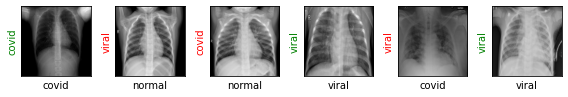

Evaluating at Step: 20
Validation Loss: 0.5539, Accuracy: 0.8444


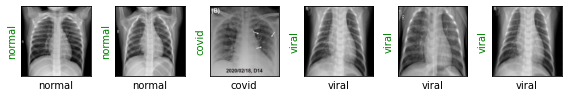

Evaluating at Step: 40
Validation Loss: 0.2986, Accuracy: 0.9111


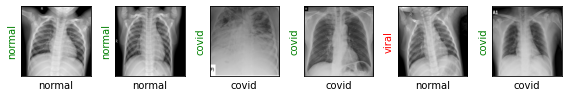

Evaluating at Step: 60
Validation Loss: 0.2557, Accuracy: 0.9333


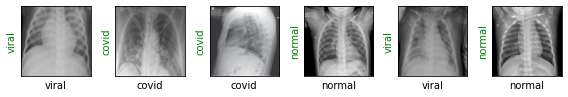

Evaluating at Step: 80
Validation Loss: 0.1576, Accuracy: 0.9667


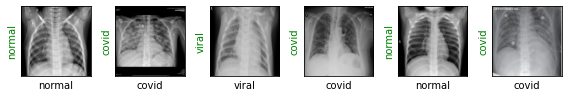

Performance of the Model (> 96% Accuracy) Condition Satisfied


In [35]:
# Train the Model for 1 Epoch
train(epochs= 1)

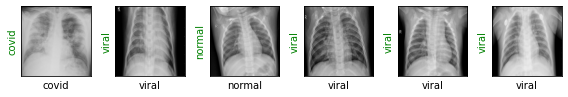

In [37]:
# Check the Predictions
show_preds()

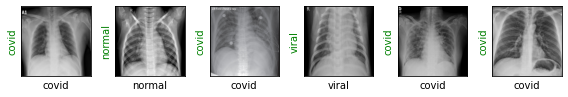

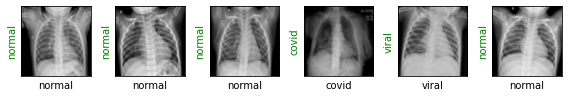

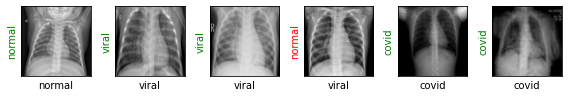

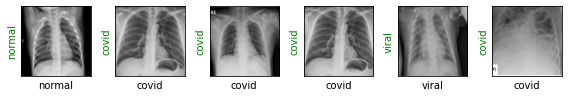

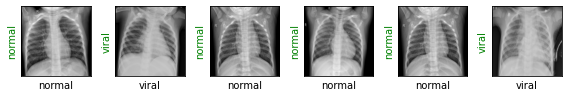

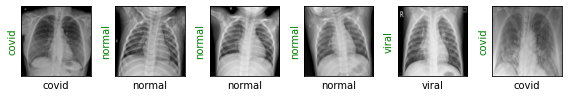

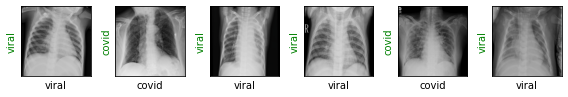

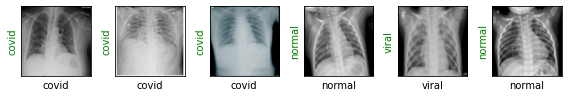

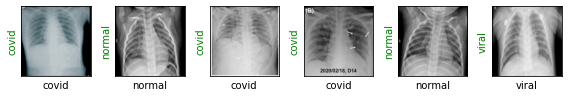

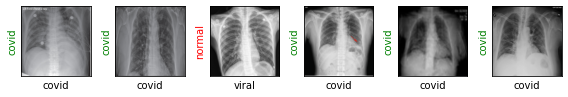

In [39]:
# Randomly Predict the Test Set for 10 Batches
for _ in range(10):
  show_preds()